In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import MLP

from RectifiedFlow import RectifiedFlow, train_rectified_flow

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 256

transform = transforms.Compose([
    #transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
v_model_1 = MLP(input_dim=28*28, layers=10, hidden_num=28*60)
rectified_flow_1 = RectifiedFlow(v_model_1, device)

In [5]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=80, verbose=True)

In [6]:
rectified_flow = train_rectified_flow(rectified_flow_1, optimizer_1, scheduler_1, train_dataloader, device, epochs=60)

Epoch 00705: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00849: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00930: reducing learning rate of group 0 to 2.5600e-03.
Epoch 01257: reducing learning rate of group 0 to 2.0480e-03.
Epoch 01338: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01419: reducing learning rate of group 0 to 1.3107e-03.


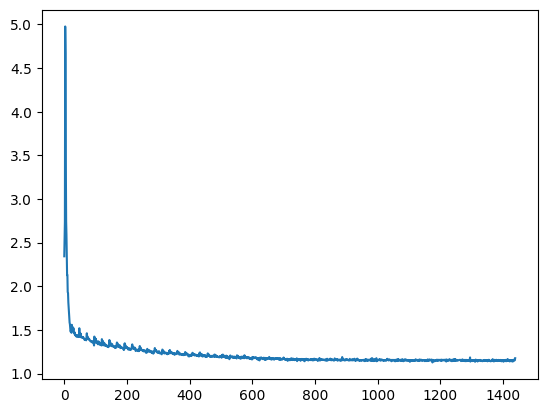

In [7]:
plt.plot(rectified_flow_1.loss_curve)
plt.show()

In [8]:
torch.save(rectified_flow_1, "./models/MNIST/MNIST_6_MLP.pth")

In [10]:
rectified_flow_1 = torch.load("./models/MNIST/MNIST_6_MLP.pth")

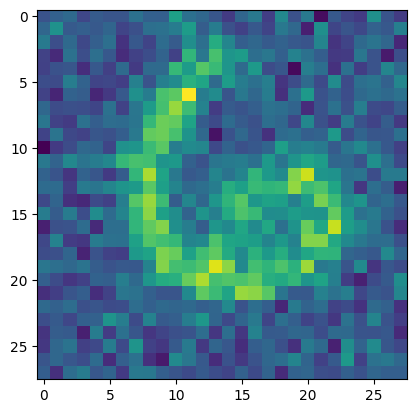

In [11]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(1,28*28).to(device) /3

img = rectified_flow_1.sample_ode(img_init, 100)

plt.imshow(img[-1][0].reshape(28,28).detach().cpu().numpy())
plt.show()

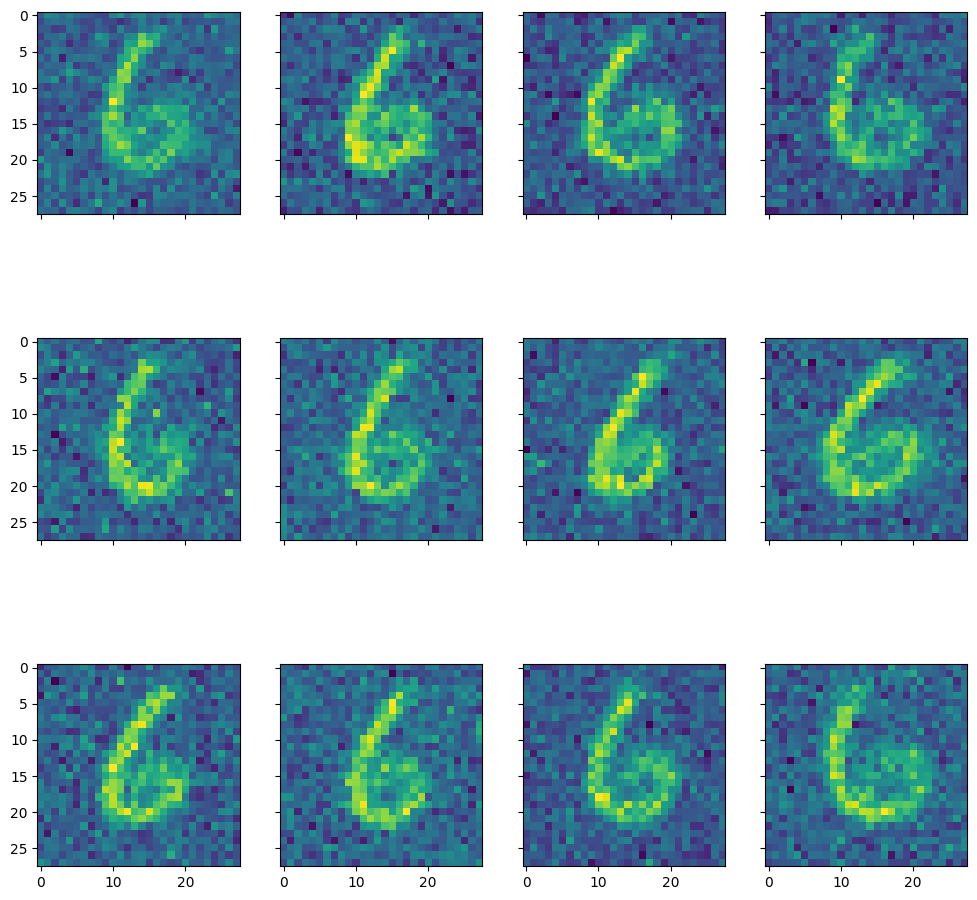

In [10]:
rectified_flow_1.v_model.eval()
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,28*28).to(device) / 3

        img = rectified_flow_1.sample_ode(img_init, 100)[-1][0].reshape(28,28).detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()